# 자동차 연비 예측하기: 회귀

In [1]:
# 산점도 행렬 그리기 위해서 seaborn 설치
!pip install -q seaborn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [12]:
# Auto MPG 데이터셋 다운로드

dataset_path=keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path


'C:\\Users\\anna4\\.keras\\datasets\\auto-mpg.data'

In [13]:
# 판다스로 데이터 읽기

column_names=['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset=pd.read_csv(dataset_path, names=column_names,
                       na_values="?", comment='\t',
                       sep=" ", skipinitialspace=True)

dataset=raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 데이터 정제하기

In [14]:
# weight에 데이터 6개가 누락되어있음
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [15]:
# 누락된 행 삭제하기

dataset=dataset.dropna()

In [16]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [17]:
# origin은 수치형이 아니라 범주형이므로 원핫인코딩으로 변환
origin=dataset.pop('Origin')

In [18]:
dataset['USA']=(origin==1)*1.0
dataset['Europe']=(origin==2)*1.0
dataset['Japan']=(origin==3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## dataset을 train dataset, test dataset으로 분할하기

In [19]:
# pandas의 sample: 무작위 샘플 추출
train_dataset=dataset.sample(frac=0.8, random_state=0)
# drop()은 선택한 값이 삭제된 객체를 반환함
# test dataset에는 train에 있는 index가 삭제된 것들이 들어감
test_dataset=dataset.drop(train_dataset.index)

## 데이터 조사하기

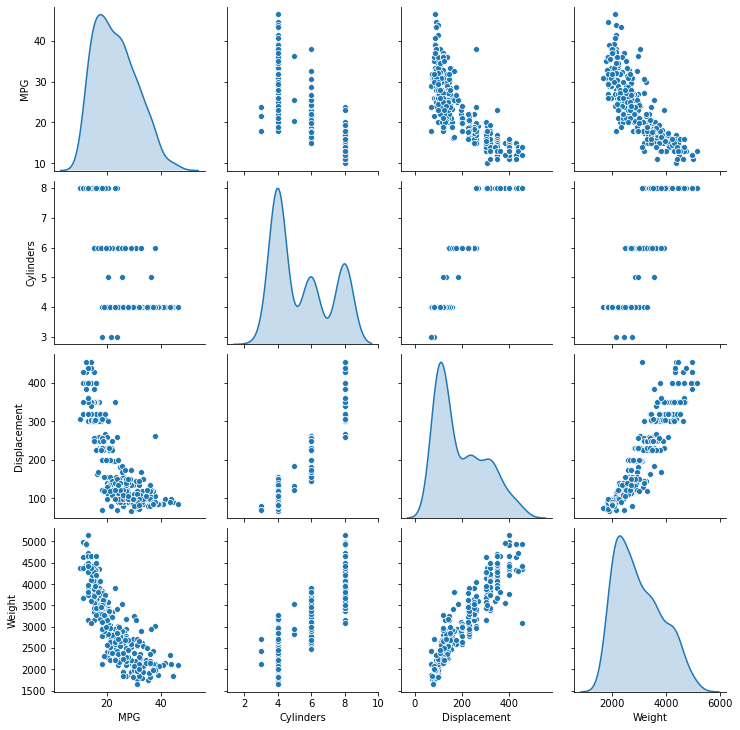

In [20]:
# train dataset에서 열 몇개 선택해 산점도 행렬 만들기

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [21]:
# 전반적인 통계
train_stats=train_dataset.describe()
train_stats.pop("MPG")
train_stats=train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 특성과 레이블 분리하기

In [22]:
train_labels=train_dataset.pop('MPG')
test_labels=test_dataset.pop('MPG')

## 데이터 정규화

In [24]:
# 왜 둘 다 train_stats로 정규화 하는거지?

def norm(x):
    return (x-train_stats['mean'])/train_stats['std']
normed_train_data=norm(train_dataset)
normed_test_data=norm(test_dataset)

## 모델 만들기

In [29]:
# 정답label을 제외하고 데이터셋의 열 개수가 들어있음
train_dataset.keys()

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

In [30]:
len(train_dataset.keys())

9

In [31]:
def build_model():
    model=keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer=tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    return model


- train_dataset.key()에는 정답label을 제외한 데이터셋의 열 개수가 들어있음
- 회귀문제라서 loss함수에 mse를 사용함
- RMSprop()안의 0.001은 learning rate

In [32]:
model=build_model()

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [35]:
# batch=10을 샘플로 만들어 모델 실행해보기
example_batch=normed_train_data[:10]
example_result=model.predict(example_batch)
example_result

array([[-0.0933302 ],
       [-0.10145487],
       [-0.69013745],
       [-0.07568265],
       [ 0.71945965],
       [-0.0746989 ],
       [ 0.7528908 ],
       [ 0.30265945],
       [-0.12676701],
       [ 0.39462268]], dtype=float32)

## 모델 훈련

In [46]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%100==0: print('')
        print('.', end='')
            
EPOCHS=1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=1,
    callbacks=[PrintDot()])

Train on 251 samples, validate on 63 samples
Epoch 1/1000
251/251 [==============================] - 0s 95us/sample - loss: 5.0604 - mae: 1.5236 - mse: 5.0604 - val_loss: 8.0862 - val_mae: 2.2259 - val_mse: 8.0862
Epoch 2/1000
251/251 [==============================] - 0s 91us/sample - loss: 5.0597 - mae: 1.5366 - mse: 5.0597 - val_loss: 7.9687 - val_mae: 2.1993 - val_mse: 7.9687
Epoch 3/1000
251/251 [==============================] - 0s 91us/sample - loss: 4.9544 - mae: 1.5093 - mse: 4.9544 - val_loss: 8.6148 - val_mae: 2.3194 - val_mse: 8.6148
Epoch 4/1000
251/251 [==============================] - 0s 91us/sample - loss: 5.0598 - mae: 1.5190 - mse: 5.0598 - val_loss: 8.6818 - val_mae: 2.3484 - val_mse: 8.6818
Epoch 5/1000
251/251 [==============================] - 0s 75us/sample - loss: 4.9936 - mae: 1.5103 - mse: 4.9936 - val_loss: 8.2597 - val_mae: 2.2176 - val_mse: 8.2597
Epoch 6/1000
251/251 [==============================] - 0s 83us/sample - loss: 5.0269 - mae: 1.4944 - mse: 5.0

251/251 [==============================] - 0s 68us/sample - loss: 4.8741 - mae: 1.4923 - mse: 4.8741 - val_loss: 8.6959 - val_mae: 2.3432 - val_mse: 8.6959
Epoch 49/1000
251/251 [==============================] - 0s 83us/sample - loss: 4.8531 - mae: 1.4644 - mse: 4.8531 - val_loss: 8.3045 - val_mae: 2.2679 - val_mse: 8.3045
Epoch 50/1000
251/251 [==============================] - 0s 72us/sample - loss: 4.8226 - mae: 1.4635 - mse: 4.8226 - val_loss: 8.3046 - val_mae: 2.2382 - val_mse: 8.3046
Epoch 51/1000
251/251 [==============================] - 0s 72us/sample - loss: 4.8305 - mae: 1.4892 - mse: 4.8305 - val_loss: 8.3049 - val_mae: 2.2468 - val_mse: 8.3049
Epoch 52/1000
251/251 [==============================] - 0s 72us/sample - loss: 4.8389 - mae: 1.5011 - mse: 4.8389 - val_loss: 8.4382 - val_mae: 2.2836 - val_mse: 8.4382
Epoch 53/1000
251/251 [==============================] - 0s 72us/sample - loss: 4.8956 - mae: 1.4773 - mse: 4.8956 - val_loss: 8.2613 - val_mae: 2.2325 - val_mse: 8

251/251 [==============================] - 0s 87us/sample - loss: 4.6465 - mae: 1.4550 - mse: 4.6465 - val_loss: 8.5178 - val_mae: 2.3003 - val_mse: 8.5178
Epoch 97/1000
251/251 [==============================] - 0s 91us/sample - loss: 4.6489 - mae: 1.4474 - mse: 4.6489 - val_loss: 8.2275 - val_mae: 2.2478 - val_mse: 8.2275
Epoch 98/1000
251/251 [==============================] - 0s 79us/sample - loss: 4.6512 - mae: 1.4218 - mse: 4.6512 - val_loss: 8.6709 - val_mae: 2.2061 - val_mse: 8.6709
Epoch 99/1000
251/251 [==============================] - 0s 79us/sample - loss: 4.7949 - mae: 1.4372 - mse: 4.7949 - val_loss: 8.6520 - val_mae: 2.2033 - val_mse: 8.6520
Epoch 100/1000
251/251 [==============================] - 0s 79us/sample - loss: 4.6855 - mae: 1.4678 - mse: 4.6855 - val_loss: 8.7158 - val_mae: 2.2014 - val_mse: 8.7158
Epoch 101/1000
251/251 [==============================] - 0s 79us/sample - loss: 4.6272 - mae: 1.4422 - mse: 4.6272 - val_loss: 8.4017 - val_mae: 2.2572 - val_mse:

251/251 [==============================] - 0s 83us/sample - loss: 4.5752 - mae: 1.4141 - mse: 4.5752 - val_loss: 8.5956 - val_mae: 2.2342 - val_mse: 8.5956
Epoch 144/1000
251/251 [==============================] - 0s 91us/sample - loss: 4.5486 - mae: 1.4099 - mse: 4.5486 - val_loss: 8.4742 - val_mae: 2.2145 - val_mse: 8.4742
Epoch 145/1000
251/251 [==============================] - 0s 91us/sample - loss: 4.4576 - mae: 1.3907 - mse: 4.4576 - val_loss: 8.8963 - val_mae: 2.2359 - val_mse: 8.8963
Epoch 146/1000
251/251 [==============================] - 0s 79us/sample - loss: 4.6480 - mae: 1.4517 - mse: 4.6480 - val_loss: 8.4503 - val_mae: 2.1864 - val_mse: 8.4503
Epoch 147/1000
251/251 [==============================] - 0s 83us/sample - loss: 4.4411 - mae: 1.4193 - mse: 4.4411 - val_loss: 8.6459 - val_mae: 2.2926 - val_mse: 8.6459
Epoch 148/1000
251/251 [==============================] - 0s 87us/sample - loss: 4.4545 - mae: 1.4415 - mse: 4.4545 - val_loss: 8.5352 - val_mae: 2.2271 - val_m

Epoch 191/1000
251/251 [==============================] - 0s 119us/sample - loss: 4.2246 - mae: 1.3530 - mse: 4.2246 - val_loss: 8.8072 - val_mae: 2.2815 - val_mse: 8.8072
Epoch 192/1000
251/251 [==============================] - 0s 99us/sample - loss: 4.3080 - mae: 1.3610 - mse: 4.3080 - val_loss: 8.9020 - val_mae: 2.2530 - val_mse: 8.9020
Epoch 193/1000
251/251 [==============================] - 0s 87us/sample - loss: 4.2413 - mae: 1.3809 - mse: 4.2413 - val_loss: 8.5612 - val_mae: 2.2410 - val_mse: 8.5612
Epoch 194/1000
251/251 [==============================] - 0s 79us/sample - loss: 4.4500 - mae: 1.4097 - mse: 4.4500 - val_loss: 8.2463 - val_mae: 2.2006 - val_mse: 8.2463
Epoch 195/1000
251/251 [==============================] - 0s 75us/sample - loss: 4.7612 - mae: 1.4424 - mse: 4.7612 - val_loss: 8.3929 - val_mae: 2.2265 - val_mse: 8.3929
Epoch 196/1000
251/251 [==============================] - 0s 79us/sample - loss: 4.2437 - mae: 1.3655 - mse: 4.2437 - val_loss: 8.4884 - val_mae

251/251 [==============================] - 0s 95us/sample - loss: 4.3699 - mae: 1.3730 - mse: 4.3699 - val_loss: 8.3648 - val_mae: 2.1856 - val_mse: 8.3648
Epoch 239/1000
251/251 [==============================] - 0s 83us/sample - loss: 4.1058 - mae: 1.3517 - mse: 4.1058 - val_loss: 8.4934 - val_mae: 2.2726 - val_mse: 8.4934
Epoch 240/1000
251/251 [==============================] - 0s 83us/sample - loss: 4.0995 - mae: 1.3579 - mse: 4.0995 - val_loss: 8.3833 - val_mae: 2.2469 - val_mse: 8.3833
Epoch 241/1000
251/251 [==============================] - 0s 91us/sample - loss: 4.2654 - mae: 1.3337 - mse: 4.2654 - val_loss: 8.2932 - val_mae: 2.2381 - val_mse: 8.2932
Epoch 242/1000
251/251 [==============================] - 0s 79us/sample - loss: 4.2804 - mae: 1.3676 - mse: 4.2804 - val_loss: 8.5990 - val_mae: 2.3196 - val_mse: 8.5990
Epoch 243/1000
251/251 [==============================] - 0s 87us/sample - loss: 4.3532 - mae: 1.3546 - mse: 4.3532 - val_loss: 8.2754 - val_mae: 2.2100 - val_m

Epoch 286/1000
251/251 [==============================] - 0s 91us/sample - loss: 4.0197 - mae: 1.3008 - mse: 4.0197 - val_loss: 8.7637 - val_mae: 2.2751 - val_mse: 8.7637
Epoch 287/1000
251/251 [==============================] - 0s 91us/sample - loss: 4.1014 - mae: 1.3245 - mse: 4.1014 - val_loss: 8.7136 - val_mae: 2.2259 - val_mse: 8.7136
Epoch 288/1000
251/251 [==============================] - 0s 83us/sample - loss: 4.2742 - mae: 1.3546 - mse: 4.2742 - val_loss: 8.5232 - val_mae: 2.2406 - val_mse: 8.5232
Epoch 289/1000
251/251 [==============================] - 0s 83us/sample - loss: 3.9922 - mae: 1.3111 - mse: 3.9922 - val_loss: 8.4481 - val_mae: 2.2434 - val_mse: 8.4481
Epoch 290/1000
251/251 [==============================] - 0s 79us/sample - loss: 4.2927 - mae: 1.3552 - mse: 4.2927 - val_loss: 8.4287 - val_mae: 2.2532 - val_mse: 8.4287
Epoch 291/1000
251/251 [==============================] - 0s 75us/sample - loss: 4.0136 - mae: 1.3123 - mse: 4.0136 - val_loss: 8.6122 - val_mae:

251/251 [==============================] - 0s 75us/sample - loss: 3.7441 - mae: 1.2615 - mse: 3.7441 - val_loss: 8.2301 - val_mae: 2.2425 - val_mse: 8.2301
Epoch 334/1000
251/251 [==============================] - 0s 75us/sample - loss: 4.2452 - mae: 1.3520 - mse: 4.2452 - val_loss: 8.3515 - val_mae: 2.2364 - val_mse: 8.3515
Epoch 335/1000
251/251 [==============================] - 0s 79us/sample - loss: 3.8941 - mae: 1.2752 - mse: 3.8941 - val_loss: 8.4537 - val_mae: 2.2614 - val_mse: 8.4537
Epoch 336/1000
251/251 [==============================] - 0s 83us/sample - loss: 3.8362 - mae: 1.2772 - mse: 3.8362 - val_loss: 8.5711 - val_mae: 2.2505 - val_mse: 8.5711
Epoch 337/1000
251/251 [==============================] - 0s 83us/sample - loss: 4.0294 - mae: 1.3436 - mse: 4.0294 - val_loss: 8.5088 - val_mae: 2.2824 - val_mse: 8.5088
Epoch 338/1000
251/251 [==============================] - 0s 83us/sample - loss: 3.8647 - mae: 1.2987 - mse: 3.8647 - val_loss: 8.5515 - val_mae: 2.2626 - val_m

Epoch 381/1000
251/251 [==============================] - 0s 79us/sample - loss: 3.8805 - mae: 1.2541 - mse: 3.8805 - val_loss: 8.5902 - val_mae: 2.2469 - val_mse: 8.5902
Epoch 382/1000
251/251 [==============================] - 0s 76us/sample - loss: 3.6027 - mae: 1.2487 - mse: 3.6027 - val_loss: 8.6456 - val_mae: 2.2937 - val_mse: 8.6456
Epoch 383/1000
251/251 [==============================] - 0s 72us/sample - loss: 3.6513 - mae: 1.2732 - mse: 3.6513 - val_loss: 8.4245 - val_mae: 2.2449 - val_mse: 8.4245
Epoch 384/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.7856 - mae: 1.2959 - mse: 3.7856 - val_loss: 9.1917 - val_mae: 2.2998 - val_mse: 9.1917
Epoch 385/1000
251/251 [==============================] - 0s 72us/sample - loss: 3.8730 - mae: 1.2929 - mse: 3.8730 - val_loss: 8.7873 - val_mae: 2.2780 - val_mse: 8.7873
Epoch 386/1000
251/251 [==============================] - 0s 79us/sample - loss: 3.7127 - mae: 1.2660 - mse: 3.7127 - val_loss: 8.7585 - val_mae:

251/251 [==============================] - 0s 87us/sample - loss: 3.5766 - mae: 1.2437 - mse: 3.5766 - val_loss: 8.6549 - val_mae: 2.3145 - val_mse: 8.6549
Epoch 429/1000
251/251 [==============================] - 0s 87us/sample - loss: 3.6248 - mae: 1.2559 - mse: 3.6248 - val_loss: 8.9095 - val_mae: 2.3729 - val_mse: 8.9095
Epoch 430/1000
251/251 [==============================] - 0s 79us/sample - loss: 3.7361 - mae: 1.2565 - mse: 3.7361 - val_loss: 8.5061 - val_mae: 2.2739 - val_mse: 8.5061
Epoch 431/1000
251/251 [==============================] - 0s 95us/sample - loss: 3.7629 - mae: 1.2550 - mse: 3.7629 - val_loss: 8.5397 - val_mae: 2.2609 - val_mse: 8.5397
Epoch 432/1000
251/251 [==============================] - 0s 83us/sample - loss: 3.5416 - mae: 1.2441 - mse: 3.5416 - val_loss: 8.6058 - val_mae: 2.2871 - val_mse: 8.6058
Epoch 433/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.6408 - mae: 1.2488 - mse: 3.6408 - val_loss: 8.7856 - val_mae: 2.3235 - val_m

Epoch 476/1000
251/251 [==============================] - 0s 107us/sample - loss: 3.6253 - mae: 1.2760 - mse: 3.6253 - val_loss: 8.6791 - val_mae: 2.3095 - val_mse: 8.6791
Epoch 477/1000
251/251 [==============================] - 0s 87us/sample - loss: 3.5290 - mae: 1.2022 - mse: 3.5290 - val_loss: 9.3290 - val_mae: 2.3769 - val_mse: 9.3290
Epoch 478/1000
251/251 [==============================] - 0s 95us/sample - loss: 3.2749 - mae: 1.1727 - mse: 3.2749 - val_loss: 9.6523 - val_mae: 2.3582 - val_mse: 9.6523
Epoch 479/1000
251/251 [==============================] - 0s 87us/sample - loss: 3.3924 - mae: 1.2339 - mse: 3.3924 - val_loss: 8.7559 - val_mae: 2.3043 - val_mse: 8.7559
Epoch 480/1000
251/251 [==============================] - 0s 83us/sample - loss: 3.4335 - mae: 1.1926 - mse: 3.4335 - val_loss: 8.6935 - val_mae: 2.3212 - val_mse: 8.6935
Epoch 481/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.4629 - mae: 1.1848 - mse: 3.4629 - val_loss: 9.0598 - val_mae

251/251 [==============================] - 0s 87us/sample - loss: 3.3507 - mae: 1.1998 - mse: 3.3507 - val_loss: 9.4340 - val_mae: 2.3354 - val_mse: 9.4340
Epoch 524/1000
251/251 [==============================] - 0s 79us/sample - loss: 3.4692 - mae: 1.2643 - mse: 3.4692 - val_loss: 8.6960 - val_mae: 2.3104 - val_mse: 8.6960
Epoch 525/1000
251/251 [==============================] - 0s 83us/sample - loss: 3.2808 - mae: 1.1739 - mse: 3.2808 - val_loss: 8.9317 - val_mae: 2.3226 - val_mse: 8.9317
Epoch 526/1000
251/251 [==============================] - 0s 83us/sample - loss: 3.4528 - mae: 1.1986 - mse: 3.4528 - val_loss: 9.0267 - val_mae: 2.3533 - val_mse: 9.0267
Epoch 527/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.3326 - mae: 1.1821 - mse: 3.3326 - val_loss: 8.8477 - val_mae: 2.3125 - val_mse: 8.8477
Epoch 528/1000
251/251 [==============================] - 0s 72us/sample - loss: 3.3953 - mae: 1.1808 - mse: 3.3953 - val_loss: 8.7412 - val_mae: 2.3079 - val_m

Epoch 571/1000
251/251 [==============================] - 0s 83us/sample - loss: 3.3782 - mae: 1.1970 - mse: 3.3782 - val_loss: 9.0743 - val_mae: 2.3111 - val_mse: 9.0743
Epoch 572/1000
251/251 [==============================] - 0s 79us/sample - loss: 3.2153 - mae: 1.1530 - mse: 3.2153 - val_loss: 8.7081 - val_mae: 2.2745 - val_mse: 8.7081
Epoch 573/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.3751 - mae: 1.2151 - mse: 3.3751 - val_loss: 9.1328 - val_mae: 2.3646 - val_mse: 9.1328
Epoch 574/1000
251/251 [==============================] - 0s 72us/sample - loss: 3.3571 - mae: 1.1650 - mse: 3.3571 - val_loss: 8.8836 - val_mae: 2.3421 - val_mse: 8.8836
Epoch 575/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.2740 - mae: 1.1567 - mse: 3.2740 - val_loss: 9.5297 - val_mae: 2.4444 - val_mse: 9.5297
Epoch 576/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.3063 - mae: 1.1782 - mse: 3.3063 - val_loss: 8.7888 - val_mae:

251/251 [==============================] - 0s 70us/sample - loss: 3.1712 - mae: 1.1614 - mse: 3.1712 - val_loss: 8.9612 - val_mae: 2.3328 - val_mse: 8.9612
Epoch 619/1000
251/251 [==============================] - 0s 74us/sample - loss: 3.3592 - mae: 1.2066 - mse: 3.3592 - val_loss: 9.1733 - val_mae: 2.3446 - val_mse: 9.1733
Epoch 620/1000
251/251 [==============================] - 0s 79us/sample - loss: 3.1311 - mae: 1.1308 - mse: 3.1311 - val_loss: 8.8540 - val_mae: 2.3128 - val_mse: 8.8540
Epoch 621/1000
251/251 [==============================] - 0s 72us/sample - loss: 3.0695 - mae: 1.1025 - mse: 3.0695 - val_loss: 9.2572 - val_mae: 2.3536 - val_mse: 9.2572
Epoch 622/1000
251/251 [==============================] - 0s 87us/sample - loss: 3.2725 - mae: 1.1782 - mse: 3.2725 - val_loss: 9.0475 - val_mae: 2.3426 - val_mse: 9.0475
Epoch 623/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.2846 - mae: 1.1202 - mse: 3.2846 - val_loss: 9.1401 - val_mae: 2.3379 - val_m

Epoch 666/1000
251/251 [==============================] - 0s 79us/sample - loss: 3.1597 - mae: 1.1050 - mse: 3.1597 - val_loss: 9.2066 - val_mae: 2.3848 - val_mse: 9.2066
Epoch 667/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.1362 - mae: 1.1779 - mse: 3.1362 - val_loss: 8.5352 - val_mae: 2.2914 - val_mse: 8.5352
Epoch 668/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.1374 - mae: 1.1439 - mse: 3.1374 - val_loss: 9.2527 - val_mae: 2.3480 - val_mse: 9.2527
Epoch 669/1000
251/251 [==============================] - 0s 72us/sample - loss: 2.9571 - mae: 1.0819 - mse: 2.9571 - val_loss: 9.1178 - val_mae: 2.3563 - val_mse: 9.1178
Epoch 670/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.2397 - mae: 1.1585 - mse: 3.2397 - val_loss: 8.8250 - val_mae: 2.3097 - val_mse: 8.8250
Epoch 671/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.0553 - mae: 1.1036 - mse: 3.0553 - val_loss: 8.9148 - val_mae:

251/251 [==============================] - 0s 75us/sample - loss: 3.0188 - mae: 1.0940 - mse: 3.0188 - val_loss: 9.0499 - val_mae: 2.3438 - val_mse: 9.0499
Epoch 714/1000
251/251 [==============================] - 0s 72us/sample - loss: 3.1646 - mae: 1.1115 - mse: 3.1646 - val_loss: 8.8656 - val_mae: 2.3260 - val_mse: 8.8656
Epoch 715/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.9305 - mae: 1.0965 - mse: 2.9305 - val_loss: 9.2005 - val_mae: 2.3428 - val_mse: 9.2005
Epoch 716/1000
251/251 [==============================] - 0s 79us/sample - loss: 3.0945 - mae: 1.1508 - mse: 3.0945 - val_loss: 8.9273 - val_mae: 2.3273 - val_mse: 8.9273
Epoch 717/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.0526 - mae: 1.1279 - mse: 3.0526 - val_loss: 9.1121 - val_mae: 2.3622 - val_mse: 9.1121
Epoch 718/1000
251/251 [==============================] - 0s 75us/sample - loss: 3.1479 - mae: 1.0899 - mse: 3.1479 - val_loss: 9.0925 - val_mae: 2.3358 - val_m

Epoch 761/1000
251/251 [==============================] - 0s 135us/sample - loss: 2.9329 - mae: 1.0769 - mse: 2.9329 - val_loss: 9.2653 - val_mae: 2.3610 - val_mse: 9.2653
Epoch 762/1000
251/251 [==============================] - 0s 95us/sample - loss: 2.9095 - mae: 1.1053 - mse: 2.9095 - val_loss: 9.1030 - val_mae: 2.3747 - val_mse: 9.1030
Epoch 763/1000
251/251 [==============================] - 0s 79us/sample - loss: 2.8957 - mae: 1.0726 - mse: 2.8957 - val_loss: 9.0887 - val_mae: 2.3873 - val_mse: 9.0887
Epoch 764/1000
251/251 [==============================] - 0s 72us/sample - loss: 3.0788 - mae: 1.1276 - mse: 3.0788 - val_loss: 8.8293 - val_mae: 2.3338 - val_mse: 8.8293
Epoch 765/1000
251/251 [==============================] - 0s 72us/sample - loss: 2.7724 - mae: 1.0371 - mse: 2.7724 - val_loss: 9.2743 - val_mae: 2.4072 - val_mse: 9.2743
Epoch 766/1000
251/251 [==============================] - 0s 79us/sample - loss: 2.9073 - mae: 1.0605 - mse: 2.9073 - val_loss: 9.3316 - val_mae

251/251 [==============================] - 0s 72us/sample - loss: 2.8919 - mae: 1.0530 - mse: 2.8919 - val_loss: 9.1359 - val_mae: 2.3664 - val_mse: 9.1359
Epoch 809/1000
251/251 [==============================] - 0s 72us/sample - loss: 2.7627 - mae: 1.0535 - mse: 2.7627 - val_loss: 9.1522 - val_mae: 2.3886 - val_mse: 9.1522
Epoch 810/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.9904 - mae: 1.1486 - mse: 2.9904 - val_loss: 9.1219 - val_mae: 2.3572 - val_mse: 9.1219
Epoch 811/1000
251/251 [==============================] - 0s 79us/sample - loss: 2.6053 - mae: 1.0131 - mse: 2.6053 - val_loss: 9.4439 - val_mae: 2.4409 - val_mse: 9.4439
Epoch 812/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.8543 - mae: 1.0711 - mse: 2.8543 - val_loss: 9.0119 - val_mae: 2.3578 - val_mse: 9.0119
Epoch 813/1000
251/251 [==============================] - 0s 72us/sample - loss: 2.9493 - mae: 1.0741 - mse: 2.9493 - val_loss: 9.5856 - val_mae: 2.4197 - val_m

Epoch 856/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.6836 - mae: 1.0408 - mse: 2.6836 - val_loss: 9.4771 - val_mae: 2.4136 - val_mse: 9.4771
Epoch 857/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.8619 - mae: 1.0734 - mse: 2.8619 - val_loss: 9.4289 - val_mae: 2.4193 - val_mse: 9.4289
Epoch 858/1000
251/251 [==============================] - 0s 72us/sample - loss: 2.6856 - mae: 0.9922 - mse: 2.6856 - val_loss: 9.2727 - val_mae: 2.3698 - val_mse: 9.2727
Epoch 859/1000
251/251 [==============================] - 0s 72us/sample - loss: 2.6445 - mae: 1.0115 - mse: 2.6445 - val_loss: 10.0860 - val_mae: 2.4937 - val_mse: 10.0860
Epoch 860/1000
251/251 [==============================] - 0s 72us/sample - loss: 2.6377 - mae: 0.9917 - mse: 2.6377 - val_loss: 9.2649 - val_mae: 2.4040 - val_mse: 9.2649
Epoch 861/1000
251/251 [==============================] - 0s 72us/sample - loss: 3.0915 - mae: 1.0987 - mse: 3.0915 - val_loss: 9.6662 - val_ma

251/251 [==============================] - 0s 75us/sample - loss: 2.6171 - mae: 1.0627 - mse: 2.6171 - val_loss: 9.5916 - val_mae: 2.4554 - val_mse: 9.5916
Epoch 904/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.6439 - mae: 1.0121 - mse: 2.6439 - val_loss: 9.5622 - val_mae: 2.4274 - val_mse: 9.5622
Epoch 905/1000
251/251 [==============================] - 0s 79us/sample - loss: 2.8157 - mae: 1.0279 - mse: 2.8157 - val_loss: 9.4209 - val_mae: 2.4219 - val_mse: 9.4209
Epoch 906/1000
251/251 [==============================] - 0s 76us/sample - loss: 2.6097 - mae: 0.9872 - mse: 2.6097 - val_loss: 9.2779 - val_mae: 2.3890 - val_mse: 9.2779
Epoch 907/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.8354 - mae: 1.0872 - mse: 2.8354 - val_loss: 9.6322 - val_mae: 2.4326 - val_mse: 9.6322
Epoch 908/1000
251/251 [==============================] - 0s 72us/sample - loss: 2.6342 - mae: 1.0173 - mse: 2.6342 - val_loss: 9.3068 - val_mae: 2.3897 - val_m

Epoch 951/1000
251/251 [==============================] - 0s 79us/sample - loss: 2.6927 - mae: 1.0260 - mse: 2.6927 - val_loss: 9.7396 - val_mae: 2.4472 - val_mse: 9.7396
Epoch 952/1000
251/251 [==============================] - 0s 68us/sample - loss: 2.7067 - mae: 1.0170 - mse: 2.7067 - val_loss: 9.5304 - val_mae: 2.4345 - val_mse: 9.5304
Epoch 953/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.5323 - mae: 0.9837 - mse: 2.5323 - val_loss: 9.7160 - val_mae: 2.4486 - val_mse: 9.7160
Epoch 954/1000
251/251 [==============================] - 0s 79us/sample - loss: 2.6688 - mae: 1.0093 - mse: 2.6688 - val_loss: 9.6539 - val_mae: 2.4405 - val_mse: 9.6539
Epoch 955/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.6024 - mae: 1.0247 - mse: 2.6024 - val_loss: 9.4248 - val_mae: 2.4532 - val_mse: 9.4248
Epoch 956/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.5502 - mae: 0.9796 - mse: 2.5502 - val_loss: 9.5147 - val_mae:

Epoch 999/1000
251/251 [==============================] - 0s 79us/sample - loss: 2.5225 - mae: 0.9716 - mse: 2.5225 - val_loss: 9.5571 - val_mae: 2.4304 - val_mse: 9.5571
Epoch 1000/1000
251/251 [==============================] - 0s 75us/sample - loss: 2.5179 - mae: 0.9989 - mse: 2.5179 - val_loss: 9.7273 - val_mae: 2.4508 - val_mse: 9.7273


In [47]:
# 모델 훈련과정 시각화

hist=pd.DataFrame(history.history)
hist['open']=history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,open
995,2.642219,1.015167,2.642219,10.131088,2.530227,10.131088,995
996,2.218712,0.912948,2.218712,10.859503,2.571636,10.859503,996
997,2.569326,1.004802,2.569326,9.626999,2.426953,9.626999,997
998,2.522549,0.971605,2.522549,9.557075,2.430448,9.557075,998
999,2.517928,0.998932,2.517928,9.727331,2.450839,9.727332,999


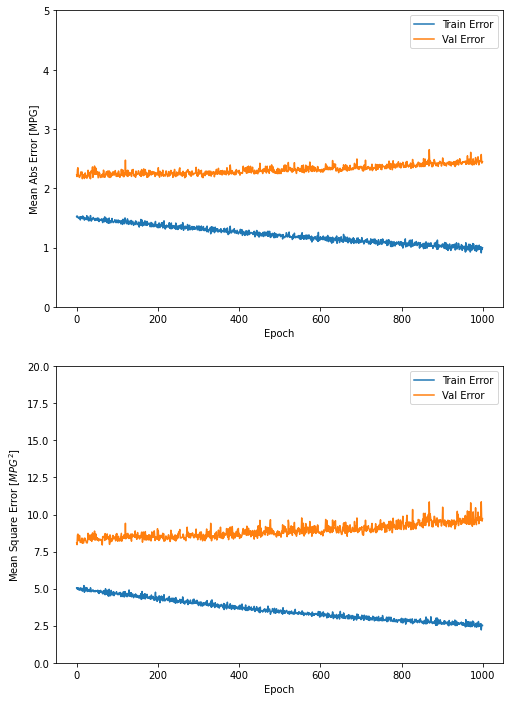

In [48]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


....................................................................................................
..............

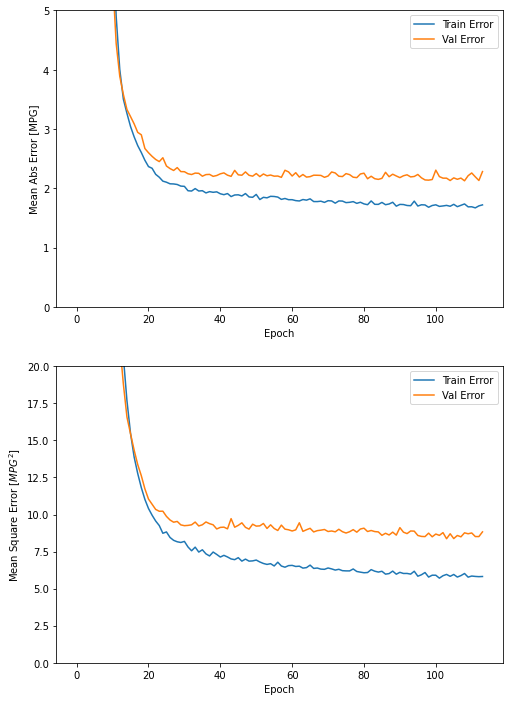

In [50]:
# 수백번 에폭을 진행한 후에는 모델이 거의 향상되지 않음
# model.fit()을 수정해 val score가 향상되지 않으면 자동으로 훈련 멈추게 하기
# earlystopping callback사용하기

model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [51]:
# test dataset에서 모델 성능 확인

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.0656 - mae: 1.8062 - mse: 6.0656
테스트 세트의 평균 절대 오차:  1.81 MPG


## 예측

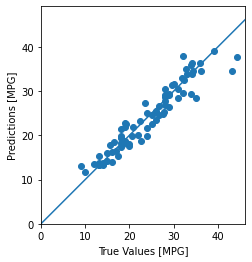

In [52]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

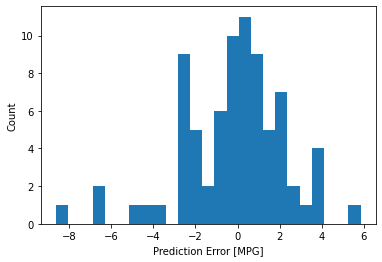

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")